## Setup

In [1]:
import os
import sys

import pandas as pd

import paths
import pickle
import importlib

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
# A helper function to add lags to the input dataset
def add_lags_inputs(inputs, num_months_lags):
    inputs = inputs.copy(deep = True)
    
    for field in inputs:
        #for i in range(min(1, num_months_lag + 1), max(1, num_months_lag+1)):
        for i in num_months_lags:
                inputs[f'{field}_lag{i}'] = inputs[field].shift(time = i)

    return inputs

In [3]:
# A helper function to format RAPID in the same way as the other output streamfunctions for training
def format_RAPID(RAPID_path):
    
    PSI_RAPID = xr.open_dataset(RAPID_path)

    PSI_RAPID['depth'] = - PSI_RAPID['depth']
    PSI_RAPID = (PSI_RAPID
                 .rename({'depth': 'Z'})
                 .rename_vars({'stream_function_mar': 'psi_moc'})
                 .assign_coords(k=('k', np.arange(len(PSI_RAPID.depth.values)))))

    PSI_RAPID['psi_moc'] = (('k', 'time'), PSI_RAPID['psi_moc'].values)
    PSI_RAPID['psi_moc'] = PSI_RAPID['psi_moc'].expand_dims({'latitude': [26.5], 'longitude': [0.0]})
    return PSI_RAPID

In [4]:
# A helper function to extract the streamfunction at the level (depth or density) where the moc is maximal in a southern (max) or northern direction (min)
def get_PSI_at_max_density_level(PSI, moc_param="psi_moc", max=True):
    PSI_mean = PSI[moc_param].mean("time")  # np.abs()
    if max is True:
        max_index = PSI_mean.argmax(dim="k")
    else:
        max_index = PSI_mean.argmin(dim="k")
    return PSI.isel(k=max_index)

In [5]:
# A helper function to format the input files based on a given latitude
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

## Experiment variables

In [6]:
data_home = paths.LOCAL_DIR

# We are specifically interested in the atlantic mask at 30S 
lat = -30
atlantic_lon_min = -50
atlantic_lon_max = 17

ECCO_GRID = xr.open_dataset(paths.geom_fp)

RAPID_path = os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc")
strf_path = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_atlantic_sf_depth.pickle"
depth_path = f"{data_home}/ecco_data_minimal/depth_range.pickle"

## Loading and preprocessing relevant data

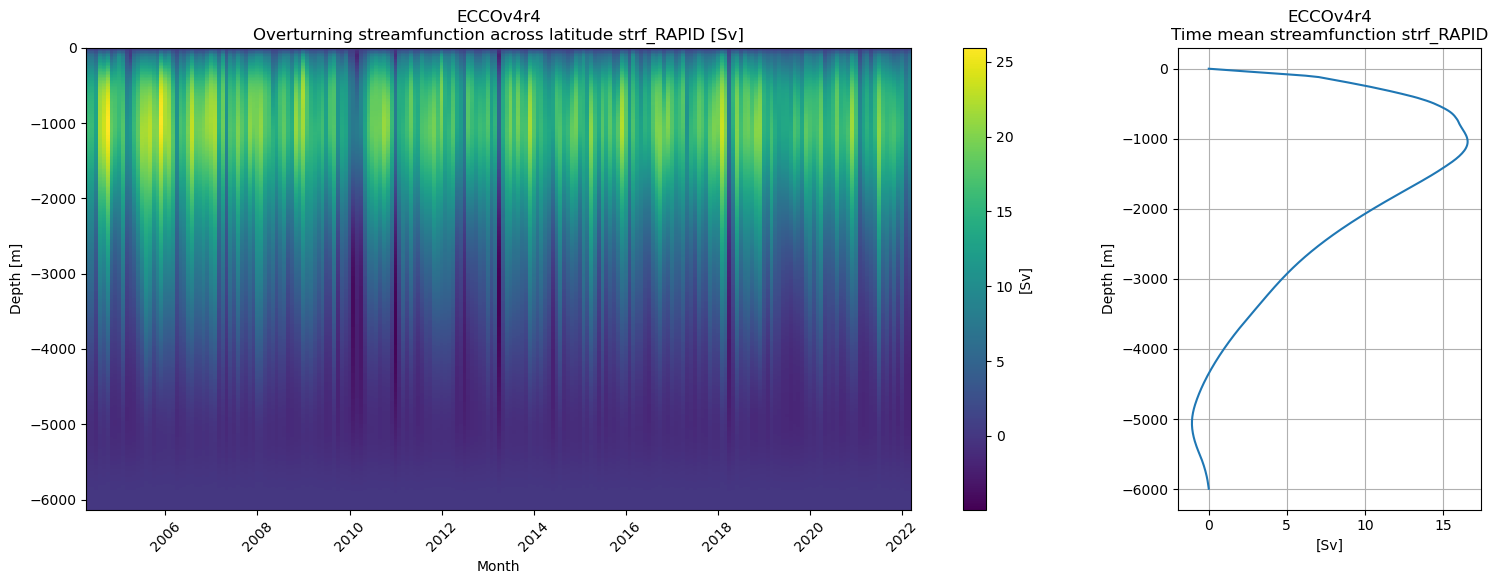

In [20]:
# Prepare the input RAPID streamfunction and resample to monthly mean values
PSI_RAPID = format_RAPID(RAPID_path).resample(time='1ME').mean()

RAPID_inputs = get_PSI_at_max_density_level(
                    PSI_RAPID, moc_param='psi_moc', max=True
                ).drop_vars('Z')
RAPID_all_inputs = add_lags_inputs(RAPID_inputs, np.arange(122))    

plot_depth_stf_vs_time(stf_ds=PSI_RAPID.squeeze(), label='strf_RAPID', param='psi_moc')

In [21]:
# Prepare the input surface variables at 30S and clip them according to the atlantic basin mask
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc").isel(latitude=slice(1,2))
inputs = inputs.sel(longitude=slice(atlantic_lon_min, atlantic_lon_max))
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 134)
Coordinates:
  * latitude   (latitude) float32 -29.75
  * longitude  (longitude) float32 -49.75 -49.25 -48.75 ... 15.75 16.25 16.75
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

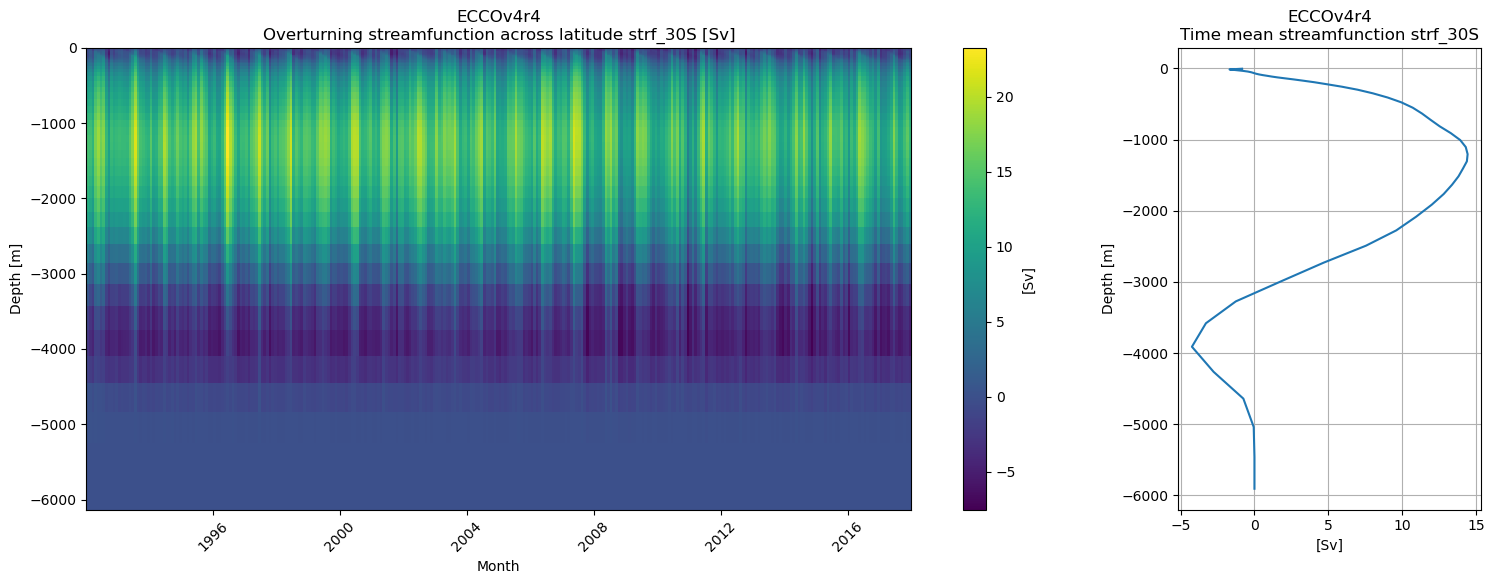

In [22]:
# Retrieve the output 30S streamfunction and calculate the moc strenght in the upper and lower cell
with open(strf_path, 'rb') as f:
    strf = pickle.load(f).astype(np.float64)[::-1]  #Invert the depth values

strf = np.expand_dims(strf[:, 1, :], 1)  # grabbing just 30S
strf = np.transpose(strf, (2, 0, 1))

strf = xr.Dataset(
    data_vars={'moc': (["time", "k", "latitude"], strf)},
    coords={'time': inputs.time, 'k': np.arange(50), 'latitude': np.atleast_1d(-60)}
)
ECCO_GRID = xr.open_dataset(paths.geom_fp)
strf = strf.assign_coords(Z=('k', ECCO_GRID.coords['Z'].data))

outputs_upper_cell = get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=True)
outputs_bottom_cell = get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=False)

plot_depth_stf_vs_time(stf_ds=strf.squeeze(), label='strf_30S', param='moc')

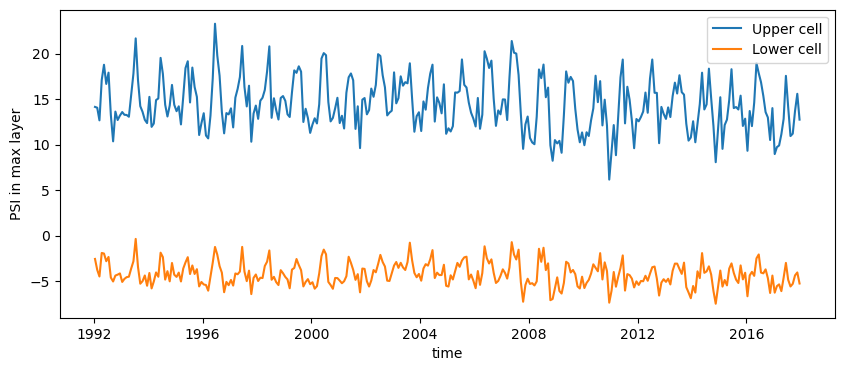

In [23]:
# Plot both streamfunctions for a sanity check
plt.figure(figsize = (10, 4))
plt.plot(outputs_upper_cell["time"].squeeze(), outputs_upper_cell["moc"].squeeze(), label='Upper cell')   
plt.plot(outputs_bottom_cell["time"].squeeze(), outputs_bottom_cell["moc"].squeeze(), label='Lower cell') 
plt.xlabel('time')
plt.ylabel('PSI in max layer')
plt.legend()

In [24]:
def clip_dates(RAPID_inputs, inputs, full_outputs):

    # RAPID has the latest start date and the ECCO data has the earliest end date (combine)
    date_range = (RAPID_inputs.dropna(dim='time', how='any').time.values[0], inputs.time.values[-1]) 
    date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
    #print('Date range to align to:', date_range)

    # Align the surface variable inputs with RAPID, then align the in- and outputs
    inputs, RAPID_inputs = align_inputs_outputs(inputs, RAPID_inputs, date_range = date_range, ecco=False)
    inputs, outputs = align_inputs_outputs(inputs, full_outputs, date_range = date_range, ecco=False)
    return inputs, RAPID_inputs, outputs

In [36]:
def preprocess_inputs(RAPID_inputs, inputs, psi_moc_variable, history=1, mode='combined'):
    # Preprocess both surface variables as the RAPID input data
    pp_data_RAPID = apply_preprocessing(RAPID_inputs,
                                    mode="inputs",
                                    remove_season=False,
                                    remove_trend=False,
                                    standardize=True,
                                    lowpass=False)

    pp_data_surface = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)
    
    coords = ["time"] # or "longitude"

    # reshape as desired and convert to a numpy array
    pp_data_RAPID_np = reshape_inputs(pp_data_RAPID, history=history, keep_coords=coords, data_vars=[psi_moc_variable], verbose=False)
    pp_data_SURFACE_np = reshape_inputs(pp_data_surface, history=history, keep_coords=coords, data_vars=["OBP", "ZWS"], verbose=False) #keep longitude for training special 

    # Concatenate the different information layers together
    if mode == 'RAPID':
        return  pp_data_RAPID_np
    elif mode == 'surface variables':
        return pp_data_SURFACE_np
    elif mode == 'combined':
        return np.concatenate((pp_data_RAPID_np, pp_data_SURFACE_np), axis=-1)

In [37]:
def preprocess_outputs(outputs, X):
    # MOC strength preprocessing
    strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
    strength_np = strength.moc.squeeze().values
    
    # Necessary step to do convolutions along the right axis with pytorch tensors!
    dims = list(range(X.ndim))  
    dims[1], dims[-1] = dims[-1], dims[1]
    
    #X = np.transpose(X, dims)

    conv_dims = 1
    if len(X.shape) == (conv_dims + 1):
        X = np.expand_dims(X, axis=-1)

    y = strength_np[-X.shape[0]:]

    return X, y

In [38]:
def define_train_and_validation_sets(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=None, random_state=123456)

    device = "cuda" if t.cuda.is_available() else "cpu"

    Xt_train = t.tensor(X_train, device=device).double()
    Yt_train = t.tensor(y_train, device=device).double()
    Xt_valid = t.tensor(X_valid, device=device).double()
    Yt_valid = t.tensor(y_valid, device=device).double()
    Xt_test = t.tensor(X_test, device=device).double()
    Yt_test = t.tensor(y_test, device=device).double()
    return Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test

In [39]:
from models import CNN_RAPID, CNN1D, train_alt
importlib.reload(CNN_RAPID)
importlib.reload(train_alt)
importlib.reload(CNN_RAPID)

<module 'models.CNN_RAPID' from 'C:\\Users\\aline\\OTP\\models\\CNN_RAPID.py'>

In [40]:
def get_input(lag_index, RAPID_all_inputs, inputs, mode='combined', history=1, cell='bottom'):

    # Decide which covariates and output to use 
    if cell == 'bottom':
        full_outputs = outputs_bottom_cell
    else:
        full_outputs = outputs_upper_cell

    psi_moc_variable = f"psi_moc_lag{lag_index}"    #Can be normal 'psi_moc' or any other lag defined above
    RAPID_inputs = RAPID_all_inputs[[psi_moc_variable]]

    inputs, RAPID_inputs, outputs = clip_dates(RAPID_inputs, inputs, full_outputs)
    X = preprocess_inputs(RAPID_inputs, inputs, psi_moc_variable, history, mode)
    X, y = preprocess_outputs(outputs, X)
    
    return define_train_and_validation_sets(X, y)

In [41]:
dropout = 0.2
n_pure_layers = 1
n_mix_layers = 2
#n_features = X.shape[1]
n_channels =  2
kernel_size = 3
model_iterations = 47
n_second_input_features = 1  

def train_CNN(Xt_train, Yt_train):

    model = CNN1D.CNN1D(
        n_pure_layers=n_pure_layers, 
        n_mix_layers=n_mix_layers, 
        n_features=Xt_train.shape[1], 
        n_channels=Xt_train.shape[1]*n_channels,
        kernel_size=kernel_size,
        dropout=dropout, 
        #n_second_input_features=n_second_input_features
    )

    model, train_loss = train_alt.train_model( #, val_loss
        model=model, 
        X_train = Xt_train, 
        y_train = Yt_train, 
        #X_val = Xt_valid,
        #y_val = Yt_valid, 
        #early_stopping=True,
        RAPID_dataset=False,
    )
    return model

In [42]:
def predict_CNN(model, Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, y_test, RAPID=False):
    model =  model.double()

    # Extracting all predictions in time order
    train_set_pred = train_alt.predict(model, Xt_train, Yt_train, RAPID_dataset=RAPID)
    valid_set_pred = train_alt.predict(model, Xt_valid, Yt_valid, RAPID_dataset=RAPID)
    test_set_pred = train_alt.predict(model, Xt_test, Yt_test, RAPID_dataset=RAPID)
    
    predictions = {
        "train_set_pred": train_set_pred, 
        "valid_set_pred": valid_set_pred, 
        "test_set_pred": test_set_pred, 
        "all_preds": np.concatenate([train_set_pred, valid_set_pred, test_set_pred])
    }
    
    metrics = {
        "rmse": round(root_mean_squared_error(test_set_pred, y_test), 3),
        "mae": round(mean_absolute_error(test_set_pred, y_test), 3),
        "mape": round(mean_absolute_percentage_error(test_set_pred, y_test), 3)*100,
        "cmape": round(custom_MAPE(np.array(test_set_pred).squeeze(), y_test.detach().cpu().numpy(), threshold=0.5), 3)*100,
        "test_corr": round(np.corrcoef(np.array(test_set_pred).squeeze(), y_test)[0, 1], 3),
        }
    
    return predictions, metrics

In [43]:
importlib.reload(train_alt)

<module 'models.train_alt' from 'C:\\Users\\aline\\OTP\\models\\train_alt.py'>

In [35]:
timelag = 1
history = 1

Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test = get_input(timelag, RAPID_all_inputs, inputs, history=history, mode='combined', cell='upper')
#Xt_train_extra, Yt_train_extra, Xt_valid_extra, Yt_valid_extra, Xt_test_extra, Yt_test_extra = get_input(timelag, RAPID_all_inputs, inputs, history=history, mode='RAPID', cell='upper')
#X = (Xt_train, Xt_train_extra)

model = train_CNN(Xt_train, Yt_train)
#predictions, metrics = predict_CNN(model, Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test )

axes: ['time', 'history', 'feature']
variables: ['psi_moc_lag1']
shape: (163, 1, 1)
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (163, 1, 2)
(163, 1, 3)
after (163, 1, 3)
device: cpu
47 parameters.


  9%|▉         | 445/5000 [00:03<00:35, 130.03it/s]


KeyboardInterrupt: 

In [184]:
predictions, metrics = predict_CNN(model, Xt_train, Yt_train,
                                   Xt_valid, Yt_valid,
                                   Xt_test, Yt_test, RAPID=False)

In [185]:
metrics

{'rmse': 1.638, 'mae': 1.276, 'mape': 9.6, 'cmape': 9.6, 'test_corr': 0.776}

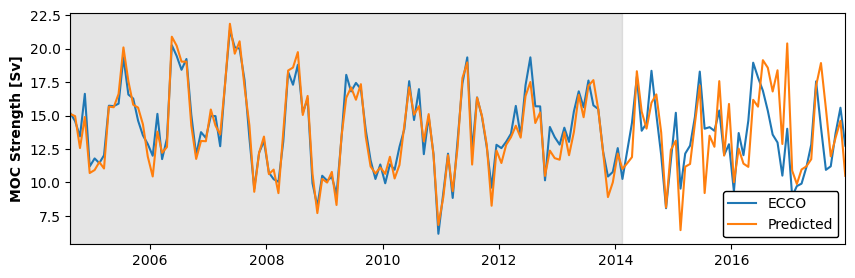

In [53]:
all_preds =predictions['all_preds']
y = np.concatenate([Yt_train, Yt_valid, Yt_test])
time = inputs.time.values[-y.shape[0]:]
fig, ax = timeseries_comparison(all_preds, y, time, len(Xt_train))
plt.show()

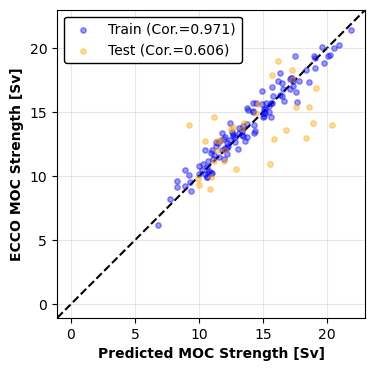

In [54]:
fig, ax = pred_vs_actual(np.array(predictions['train_set_pred']).squeeze(),
                         np.array(predictions['test_set_pred']).squeeze(),
                         Yt_train, Yt_test)
plt.show()

### To Loop over several trainings and compare the outputs

In [44]:
# To loop over several models and compare the performances
models = []
for i in range(122):
    print('training', i)
    Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test = get_input(i, RAPID_all_inputs, inputs)
    models.append(train_CNN(Xt_train, Yt_train))

predictions_models = []
metrics_models = []

for i in range(len(models)):
    Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test = get_input(i+1, RAPID_all_inputs, inputs)
    predictions, metrics = predict_CNN(models[i], Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test )
    predictions_models.append(predictions)
    metrics_models.append(metrics)

metrics_df = pd.DataFrame(metrics_models)
summary_metrics_df = pd.DataFrame({
                "mean": metrics_df.mean().round(3), 
                "std": metrics_df.std().round(3)}
            )
display(summary_metrics_df)

predictions_df = pd.DataFrame(predictions_models)

training 0
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:35<00:00, 140.81it/s]


training 1
device: cpu
47 parameters.


100%|██████████| 5000/5000 [08:39<00:00,  9.62it/s] 


training 2
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:46<00:00, 106.88it/s]


training 3
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:46<00:00, 106.77it/s]


training 4
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:42<00:00, 117.63it/s]


training 5
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:40<00:00, 123.81it/s]


training 6
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:38<00:00, 128.29it/s]


training 7
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:40<00:00, 122.23it/s]


training 8
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:40<00:00, 123.23it/s]


training 9
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:36<00:00, 136.46it/s]


training 10
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:35<00:00, 140.00it/s]


training 11
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:43<00:00, 115.67it/s]


training 12
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:43<00:00, 116.13it/s]


training 13
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:42<00:00, 117.30it/s]


training 14
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:39<00:00, 125.26it/s]


training 15
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:39<00:00, 127.58it/s]


training 16
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:40<00:00, 122.58it/s]


training 17
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:43<00:00, 115.85it/s]


training 18
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:39<00:00, 127.35it/s]


training 19
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:43<00:00, 115.83it/s]


training 20
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:41<00:00, 121.87it/s]


training 21
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:40<00:00, 124.48it/s]


training 22
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:40<00:00, 123.56it/s]


training 23
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:43<00:00, 115.88it/s]


training 24
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:41<00:00, 120.15it/s]


training 25
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:39<00:00, 127.89it/s]


training 26
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:43<00:00, 116.11it/s]


training 27
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:41<00:00, 119.78it/s]


training 28
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:40<00:00, 123.15it/s]


training 29
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:40<00:00, 123.10it/s]


training 30
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:39<00:00, 127.62it/s]


training 31
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:41<00:00, 121.56it/s]


training 32
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:39<00:00, 126.85it/s]


training 33
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 149.86it/s]


training 34
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:36<00:00, 138.58it/s]


training 35
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:37<00:00, 132.05it/s]


training 36
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:37<00:00, 132.26it/s]


training 37
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:37<00:00, 132.27it/s]


training 38
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:36<00:00, 137.34it/s]


training 39
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:36<00:00, 136.43it/s]


training 40
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:39<00:00, 126.19it/s]


training 41
device: cpu
47 parameters.


100%|██████████| 5000/5000 [01:24<00:00, 59.24it/s] 


training 42
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:41<00:00, 120.09it/s]


training 43
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:34<00:00, 145.95it/s]


training 44
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:34<00:00, 145.26it/s]


training 45
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:42<00:00, 117.56it/s]


training 46
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:38<00:00, 131.45it/s]


training 47
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:38<00:00, 128.83it/s]


training 48
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:39<00:00, 125.50it/s]


training 49
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:36<00:00, 138.17it/s]


training 50
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:38<00:00, 131.37it/s]


training 51
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:42<00:00, 118.08it/s]


training 52
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:44<00:00, 113.16it/s]


training 53
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:40<00:00, 122.49it/s]


training 54
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:41<00:00, 120.57it/s]


training 55
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:42<00:00, 116.43it/s]


training 56
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:34<00:00, 144.94it/s]


training 57
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 155.91it/s]


training 58
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 154.68it/s]


training 59
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:34<00:00, 145.95it/s]


training 60
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:34<00:00, 146.78it/s]


training 61
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 151.70it/s]


training 62
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 153.09it/s]


training 63
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 151.07it/s]


training 64
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 149.73it/s]


training 65
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 155.71it/s]


training 66
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 150.46it/s]


training 67
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:40<00:00, 123.85it/s]


training 68
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:41<00:00, 121.78it/s]


training 69
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:35<00:00, 140.53it/s]


training 70
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 149.57it/s]


training 71
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:31<00:00, 156.80it/s]


training 72
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:31<00:00, 159.92it/s]


training 73
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 153.46it/s]


training 74
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 155.52it/s]


training 75
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:31<00:00, 156.71it/s]


training 76
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 152.83it/s]


training 77
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 150.80it/s]


training 78
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 150.64it/s]


training 79
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 150.77it/s]


training 80
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 149.98it/s]


training 81
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 153.86it/s]


training 82
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 153.00it/s]


training 83
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:31<00:00, 159.55it/s]


training 84
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 155.75it/s]


training 85
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 151.71it/s]


training 86
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 154.76it/s]


training 87
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 149.62it/s]


training 88
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:34<00:00, 146.29it/s]


training 89
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 153.43it/s]


training 90
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:36<00:00, 135.17it/s]


training 91
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:34<00:00, 145.46it/s]


training 92
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 153.25it/s]


training 93
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:35<00:00, 142.66it/s]


training 94
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:35<00:00, 140.60it/s]


training 95
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 152.79it/s]


training 96
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 151.98it/s]


training 97
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 150.36it/s]


training 98
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 151.03it/s]


training 99
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 153.28it/s]


training 100
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 147.18it/s]


training 101
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 155.97it/s]


training 102
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 155.85it/s]


training 103
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 151.03it/s]


training 104
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 154.89it/s]


training 105
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 155.21it/s]


training 106
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 153.17it/s]


training 107
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 149.68it/s]


training 108
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 154.40it/s]


training 109
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 156.21it/s]


training 110
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:31<00:00, 156.30it/s]


training 111
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 152.06it/s]


training 112
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 154.17it/s]


training 113
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 149.17it/s]


training 114
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 154.53it/s]


training 115
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 152.72it/s]


training 116
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 148.41it/s]


training 117
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:33<00:00, 151.30it/s]


training 118
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:35<00:00, 141.65it/s]


training 119
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 155.25it/s]


training 120
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:32<00:00, 152.73it/s]


training 121
device: cpu
47 parameters.


100%|██████████| 5000/5000 [00:31<00:00, 156.72it/s]


KeyError: 'psi_moc_lag122'

In [45]:
metrics_df = pd.DataFrame(metrics_models)
summary_metrics_df = pd.DataFrame({
                "mean": metrics_df.mean().round(3), 
                "std": metrics_df.std().round(3)}
            )
display(summary_metrics_df)

predictions_df = pd.DataFrame(predictions_models)
metrics_df

,mean,std
rmse,0.880,0.157
mae,0.715,0.133
mape,16.922,4.056
cmape,16.922,4.056
test_corr,0.647,0.152


,rmse,mae,mape,cmape,test_corr
0,0.739,0.614,13.6,13.6,0.794
1,0.983,0.798,18.1,18.1,0.407
2,1.033,0.845,21.0,21.0,0.470
3,0.823,0.633,14.2,14.2,0.755
4,1.174,0.973,25.6,25.6,0.304
...,...,...,...,...,...
116,0.942,0.783,19.6,19.6,0.498
117,1.097,0.840,25.0,25.0,0.657
118,0.781,0.639,14.7,14.7,0.853
119,0.786,0.638,15.8,15.8,0.707


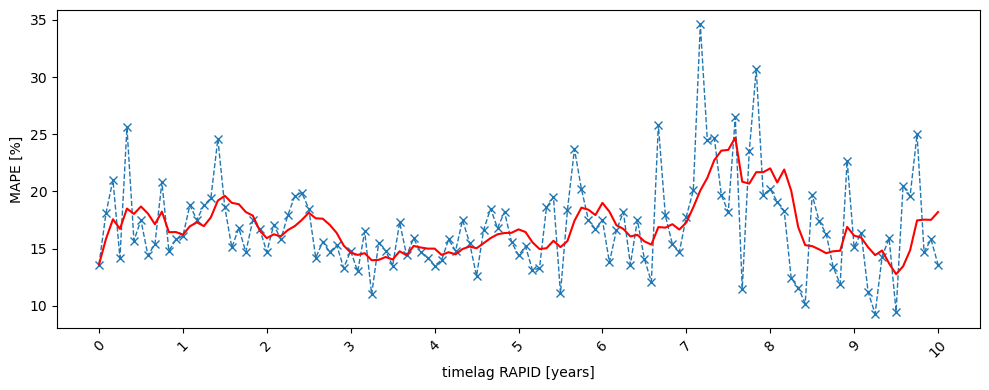

In [53]:
# Plotting
rolling_mean = metrics_df['mape'].rolling(window=6, min_periods=1).mean()

plt.figure(figsize=(10, 4))  # Optional: specifies the figure size
plt.plot(metrics_df.index, metrics_df['mape'], marker='x', linestyle='--', linewidth=1.0, label='1D-CNN results')  
plt.plot(metrics_df.index, rolling_mean, color='red', label='')
plt.xlabel('timelag RAPID [years]', weight="bold")
plt.ylabel('MAPE [%]', weight="bold")
plt.xticks(np.arange(0, 122, 12), labels=[f'{i}' for i in range(11)], rotation=45) 
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.legend()
plt.show()

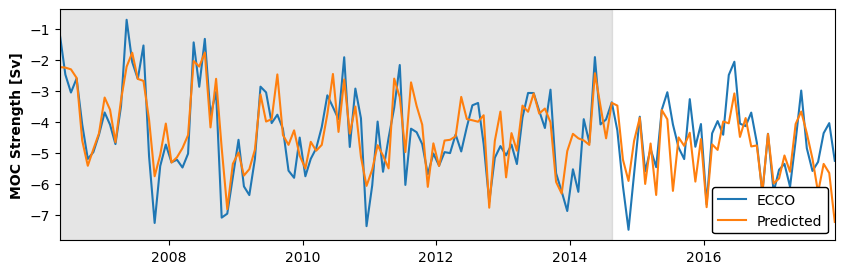

In [137]:
mean_arrays = {col: np.mean(np.stack(predictions_df[col].values), axis=0) for col in predictions_df}
all_preds = mean_arrays['all_preds']
time = outputs.time.values[-X.shape[0]:]
fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

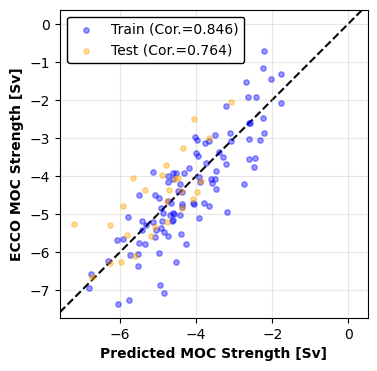

In [138]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(mean_arrays['train_set_pred']).squeeze()
y_pred_test = np.array(mean_arrays['test_set_pred']).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()